In [40]:
from LABNET import Neuron, Net, Lab

In [41]:
import random
import numpy as np
import matplotlib.pyplot as plt


In [89]:
def plot_line_graph(numbers,window_size = 1,plot_size = (10,6) ):
    if window_size <= 0 or window_size > len(numbers):
        raise ValueError("Invalid window size")
    
    running_sum = sum(numbers[:window_size])
    averages = [running_sum / window_size]

    for i in range(window_size, len(numbers)):
        running_sum += numbers[i] - numbers[i - window_size]
        averages.append(running_sum / window_size)
    
    
    x = range(1, len(averages) + 1)  
    y = averages  # y-axis values
    plt.figure(figsize=plot_size)
    plt.plot(x, y)  # Plotting the line graph
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('loss')

    plt.show() 

In [43]:
def create_neural_network(layer_sizes):
    # Extract the number of inputs and outputs from the layer_sizes list
    num_inputs = layer_sizes[0]
    num_outputs = layer_sizes[-1]
    
    # Create a sequential model
    model = nn.Sequential()
    
    # Add input layer
    model.add_module("input_layer", nn.Linear(num_inputs, layer_sizes[1]))
    model.add_module("input_layer_activation", nn.ReLU())
    
    # Add hidden layers
    for i in range(2, len(layer_sizes)-1):
        model.add_module(f"hidden_layer_{i}", nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        model.add_module(f"hidden_layer_{i}_activation", nn.ReLU())
    
    # Add output layer
    model.add_module("output_layer", nn.Linear(layer_sizes[-2], num_outputs))
    #model.add_module("output_layer_activation", nn.ReLU())
    #model = model.to(dtype=torch.float)
    return model

def initialize_weights_uniform(neural_network, low=-10, high=10):
    for module in neural_network.modules():
        if isinstance(module, nn.Linear):
            init.uniform_(module.weight, low, high)
            if module.bias is not None:
                init.uniform_(module.bias, low, high)

import torch
from torch.distributions import uniform, normal

def generate_random_data(gen_model,n, dist_type = 'normal',  m =0, std=1, gen_lr = 0.01):
    
    input_size = gen_model.input_layer.in_features ##this only works with create_neural_network func above
    output_size = gen_model.output_layer.out_features
    
    samples = np.random.normal(m, std, (n,input_size))
    samples = torch.from_numpy(samples).float()
    out_temp = np.random.normal(m, std, (n,output_size))
    out_temp = torch.from_numpy(out_temp).float()
    ##train for a few epochs to get decent weights
    ##random weights end up generating a lot of the same targets for random inputs.  its weird.  
    ##talk to kulis about this 
    criterion = nn.MSELoss()
    optimizer = optim.SGD(gen_model.parameters(), lr=gen_lr)

    # Set the number of epochs
    num_epochs = 100

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = gen_model(samples)
        loss = criterion(outputs.squeeze(), out_temp)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    
    ##after its trained a bit, it uses those weights to make "perfect" outputs
    outputs_return = gen_model(samples)  
    
    return samples,outputs_return.detach() ##if you don't detach it tries to backprop, this just makes it data

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

In [45]:
import torch.nn.init as init

n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = create_neural_network(layer_sizes)
#initialize_weights_uniform(neural_network,0,1)

gen_inputs, gen_outputs = generate_random_data(neural_network,n,'normal',-1,1)



In [379]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        self.hidden_3 = nn.Linear(7,7)
        self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.relu(self.hidden_3(x))
        x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [380]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (hidden_3): Linear(in_features=7, out_features=7, bias=True)
  (hidden_4): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
)


In [381]:
criterion = nn.MSELoss()
optimizer = optim.SGD(mymodel.parameters(), lr=0.05)

In [382]:
input_data = gen_inputs
output_data = gen_outputs

In [383]:
# Training loop
#samples = n
samples = input_data.shape[0]
print(samples)
num_epochs = 10

lab = Lab(mymodel,num_epochs,samples)
data = list(zip(input_data, output_data))

losses = []

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = mymodel(inputs)
        
        loss = criterion(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lab.record(mymodel,epoch,samples,sample)
        #print or store loss if you wanna
        losses.append(loss.item())

        
        sample += 1
 


1000


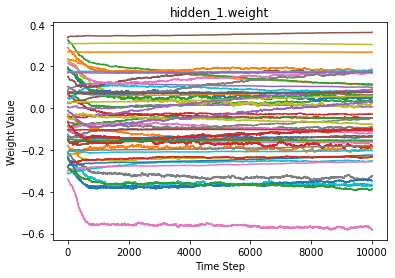

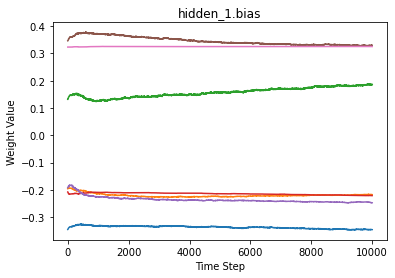

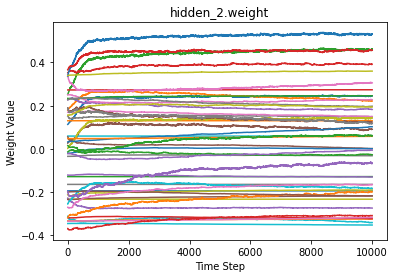

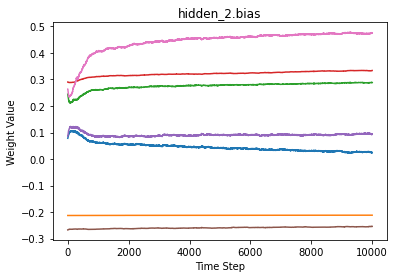

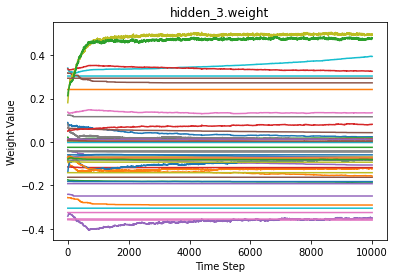

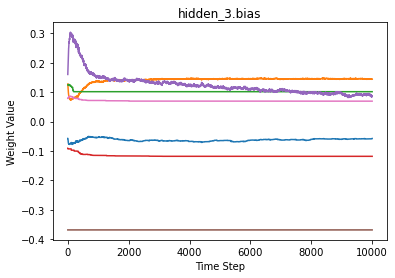

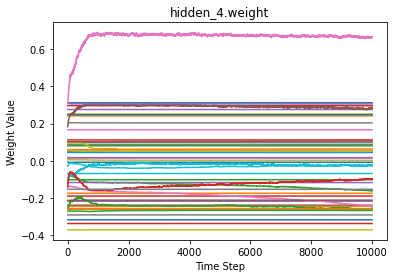

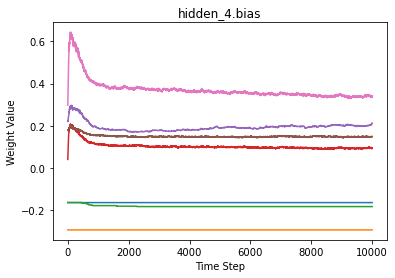

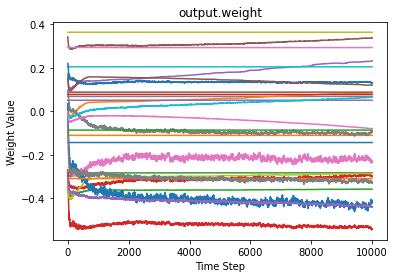

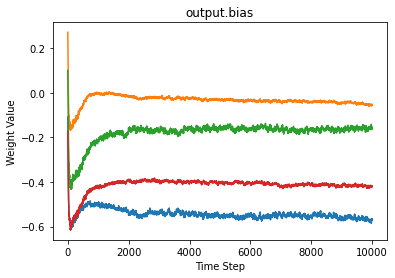

In [384]:
lab.graph(diff=0)

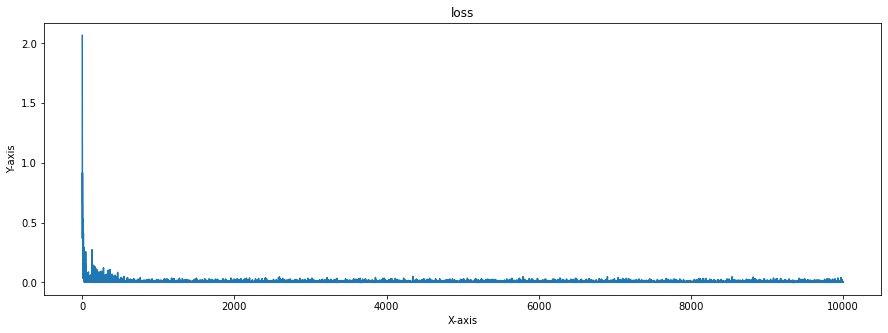

In [385]:
plot_line_graph(losses,window_size = 1, plot_size = (15,5)) #window_size is the moving average window

56


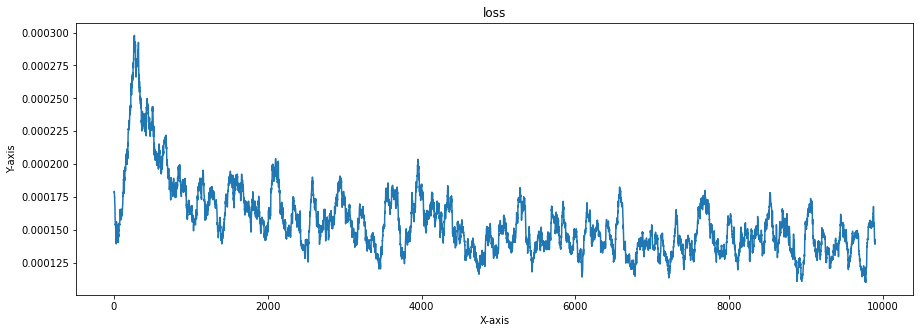

In [386]:
o_w = lab.LabParams['hidden_1.weight'].flatten(start_dim = 1)
print(o_w.shape[1])
o_w = o_w.detach().numpy()
o_w = np.diff(o_w, axis = 0)
o_w_ms = np.sum(np.abs(o_w), axis = 1)/o_w.shape[1]
o_w_ms_list = o_w_ms.tolist()
plot_line_graph(o_w_ms_list,window_size = 100, plot_size = (15,5))

In [387]:
#add a zoom feature to the graphs? give it an x axis range and zoom? stretch the graph too.

In [ ]:
over parameterized it converges fast? strict definition of overparameterized, is it part of shape? mess with concat?

the first few samples are absolutely contingent on the initialization, the correct architecture has the lowest fluctuations in the weights, the number of parameters affects the beginning (anecdotal, more evidence) and the number or layers affects the best possible fluctuations in the tail.  

